# Hourly clustering over whole year 2024

In [30]:
import polars as pl
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from pathlib import Path
import re
import pandas as pd

from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True
from validation import validation_kMeans
from cluster_statistics import plot_cluster_percentiles
from Hyperparameters_KMeans import optimize_kmeans

In [31]:
data_set = "SWW"    # Options: "SWW", "GroupE"
building_type = "flat" # "flat" or "house"
number_of_clusters = 6

## Data extraction and preprocessing

In [32]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_cleaned")
output_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_hourlyAveraged_normalized")
output_folder.mkdir(parents=True, exist_ok=True)

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

def day_avg_preprocess(df):
    # Parse the timestamp column (assuming 'timestamp' column exists)
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
    # Extract time_of_day (hour, minute) as time component
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.time().alias("time_of_day")
    )
    # Group by time_of_day across all days in the range and average the energy column
    day_avg = (
        df.group_by("time_of_day")
          .agg(pl.col("bruttolastgang_kwh").mean().alias("day_avg_bruttolastgang_kwh"))
          .sort("time_of_day")
    )
    return day_avg

def normalize(df):  
    """ Normalize the 'day_avg_bruttolastgang_kwh' column by its max value and overwrite the original column """
    max_val = df.select(pl.max("day_avg_bruttolastgang_kwh"))['day_avg_bruttolastgang_kwh'][0]
    
    if max_val == 0:
        # Avoid division by zero, leave values unchanged
        df = df.with_columns(
            pl.col("day_avg_bruttolastgang_kwh")
        )
    else:
        # Overwrite original column with normalized values
        df = df.with_columns(
            (pl.col("day_avg_bruttolastgang_kwh") / max_val).alias("day_avg_bruttolastgang_kwh")
        )
    return df

for file_path in file_paths:
    df = pl.read_csv(file_path)
    time_avg = day_avg_preprocess(df)
    time_avg = normalize(time_avg)
    
    filename = os.path.basename(file_path)  # Original file name
    output_file = output_folder / filename  # Output path with same filename
    
    time_avg.write_csv(output_file)

## Data Clustering

In [33]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_hourlyAveraged_normalized")
pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

key_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/00_SWW_ID_smartmeter.xlsx"
key_df = pd.read_excel(key_path, header=None)

# Load the Excel file
file_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/Survey_Data.xlsx"
# Read without headers, so columns are numbered 0,1,2,...
df = pd.read_excel(file_path, skiprows=4, nrows=1500, header=None)
#['tenant type', 'age', 'monthly income', 'education level', 'employment status']
# Now columns 10 and 131 correspond to Excel columns K and Q exactly (0-based)
cols_to_extract = [10, 142]
extracted_df = df.iloc[:, cols_to_extract]

# Assign your own headers
extracted_df.columns = ['house-id', 'Building Type']

extracted_df_pl = pl.from_pandas(extracted_df)

total_rows = extracted_df_pl.height

# Count unique house_id values
unique_house_ids = extracted_df_pl["house-id"].n_unique()

print(f"Total rows: {total_rows}")
print(f"Unique house-id count: {unique_house_ids}")

if total_rows > unique_house_ids:
    print(f"There are {total_rows - unique_house_ids} duplicate house_id entries.")
else:
    print("No duplicates found in house_id column.")

# Column 1 (index 0) has original house IDs, column 2 (index 1) has CH... identifiers
# Create a mapping dict: {house_id: CH_id}
mapping = dict(zip(key_df.iloc[:,0], key_df.iloc[:,2]))

# Map 'house-id' in extracted_df to 'CH...' values
# Safely assign new column using .loc to avoid SettingWithCopyWarning
extracted_df = extracted_df.copy()
extracted_df['CH_id'] = extracted_df['house-id'].map(mapping)

# Drop rows where 'Building Type' is 'House'
category_df = extracted_df.copy()


rows_to_keep_indices = []

exclude_building_type = building_type

if building_type == "house":
    exclude_building_type = "Flat"
elif building_type == "flat":
    exclude_building_type = "House"

for i, row in category_df.iterrows():
    # Check if 'No Information' NOT in any value of that row
    if "No Information" not in row.values:
        # Check if 'Flat' NOT in any value of that row
        if exclude_building_type not in row.values:
            rows_to_keep_indices.append(i)

category_df = category_df.drop(columns=['Building Type'])
category_df = category_df.drop(columns=['house-id'])

category_df = category_df.iloc[rows_to_keep_indices]




Total rows: 1500
Unique house-id count: 1500
No duplicates found in house_id column.


In [34]:
n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    
    if pattern.search(os.path.basename(file_path)).group(1) in category_df['CH_id'].values:  
        if len(df) == n_timestamps:
            values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
            data_list.append(values_array)
            
            base = os.path.basename(file_path)
            match = pattern.search(base)
            if match:
                filename_list.append(match.group(1))
            else:
                filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

#print(filename_list[:10])  # Preview first 10 extracted CH... names

train_data = data_3d

Shape of the 3D array: (801, 96, 1)


# Validation Metric
Default runs Davies-Bouldin, Silhoutte score and Calinski Harabasz scores can be plotted by uncommenting few lines

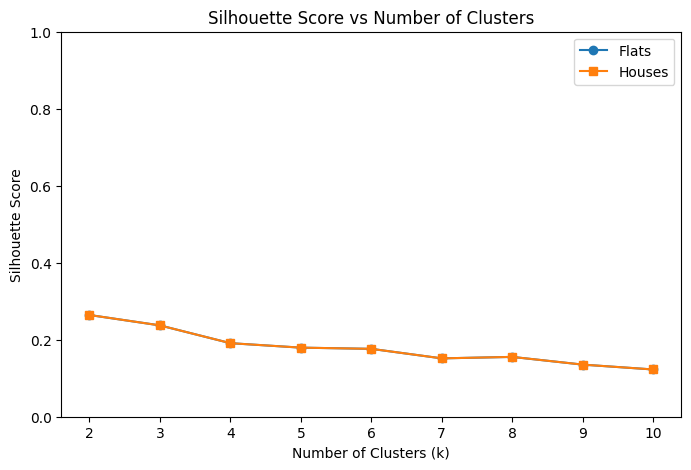

Minimum Silhouette Score Dataset 1: 0.26421292992626655
Minimum Silhouette Score Dataset 2: 0.26421292992626655
0.19104670516189193
1.4990932807065254


In [35]:
from importlib import reload
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import validation
from validation import validation_kMeans
reload(validation)
validation_kMeans(train_data, train_data)

#optimize_kmeans(train_data)

kmeans = TimeSeriesKMeans(n_clusters=4,max_iter=500, verbose=False, random_state=42,n_init=2, n_jobs=-1)
labels_clusters = kmeans.fit_predict(train_data.reshape((train_data.shape[0], train_data.shape[1])))
            
sh = silhouette_score(train_data.reshape((train_data.shape[0], train_data.shape[1])), labels_clusters)
db = davies_bouldin_score(train_data.reshape((train_data.shape[0], train_data.shape[1])), labels_clusters)

print(sh)
print(db)


# K-means Clustering
change n_clusters as required

In [36]:
max_iterations =200
n_init = 3

kmeans = TimeSeriesKMeans(n_clusters=number_of_clusters, max_iter=max_iterations, verbose=False, random_state=42,n_init=n_init, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

# Plotting the cluster average patterns

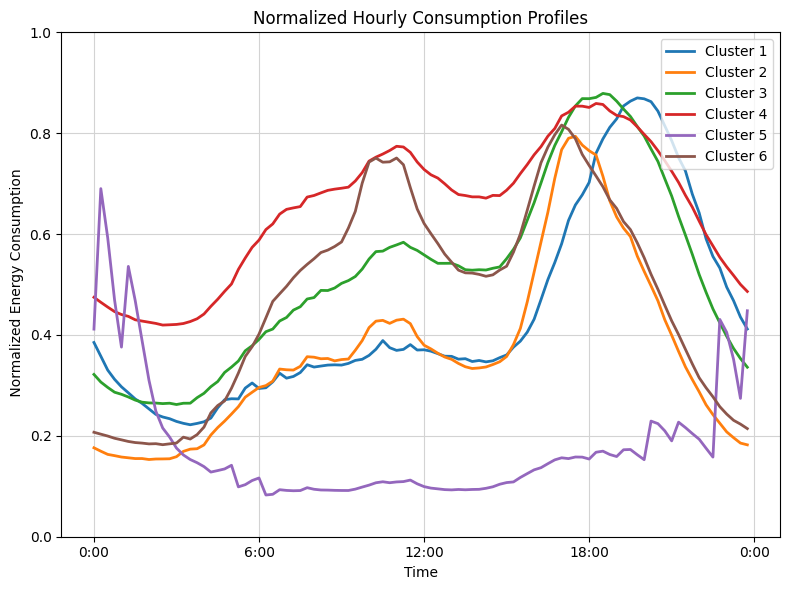

In [37]:
labels = ['0:00','6:00','12:00','18:00','0:00']

colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

n_clusters = len(np.unique(clusters_train))

plt.figure(figsize=(8,6))
for cluster_idx in range(n_clusters):
    # Get all time series in this cluster
    cluster_data = train_data[clusters_train == cluster_idx]
    cluster_indices = np.where(clusters_train == cluster_idx)[0]    

    # Calculate the mean time series for the cluster
    mean_time_series = np.mean(cluster_data, axis=0)
    
    # Plot the mean time series
    cluster_no = cluster_idx+1
    plt.plot(range(1,97), mean_time_series.ravel(), 
            label= f'Cluster {cluster_no}',
            linewidth =2, color=colors[cluster_idx] )
plt.title(f'Normalized Hourly Consumption Profiles')
plt.xlabel("Time")
plt.ylabel(" Normalized Energy Consumption")
plt.ylim(0,1)
plt.xticks(range(1,120,24),labels=labels)
plt.tight_layout()
plt.grid(True, color = 'lightgray')
plt.legend(
loc='upper right',
bbox_to_anchor=(1, 1),
ncol=1,
fontsize='medium'
)
plt.savefig(
f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Cluster/HourlyAveraged_KMeans_{building_type}.png",
bbox_inches='tight'
)
plt.show()

## Actual energy consumption of each cluster

In [38]:
# saves the found clusters in a csv file with the corresponding household IDs

# Convert filename_list items to strings
house_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters_train + 1
}).sort("cluster")

result_df.write_csv(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/DATA/Cluster/hourly_avg_clustering_kMeans_{building_type}.csv")




In [39]:


# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption"
    ]),
    on="ch_id_clean",
    how="left"
)
# Now select in the desired order
result_df = result_df.select([
    "house_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption"  
])

#print(result_df.head())

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_yearly_consumption [kWh]").round(2),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]").round(2)
]).sort("cluster")

# Compute overall averages
overall_yearly_avg = round(result_df["bruttolastgang_kwh_sum"].mean(),2)
overall_seasonal_avg = round(result_df['average_daily_consumption'].mean(),2)

cluster_summary = cluster_summary.with_columns([
    pl.col("cluster").cast(pl.Utf8)
])
summary_row = pl.DataFrame({
    "cluster": ["Combined"],  # Use 0 or a valid UInt32 value for summary row
    "num_households": [result_df["house_id"].n_unique()],
    "avg_yearly_consumption [kWh]": [overall_yearly_avg],
    "avg_daily_consumption [kWh]": [overall_seasonal_avg]
})

# Cast to match schema, e.g. cluster and num_households to UInt32
summary_row = summary_row.with_columns([
    pl.col("cluster").cast(cluster_summary["cluster"].dtype),
    pl.col("num_households").cast(cluster_summary["num_households"].dtype)
])

# Concatenate now that dtypes match
final_summary = pl.concat([cluster_summary, summary_row])

print(final_summary)



shape: (7, 4)
┌──────────┬────────────────┬──────────────────────────────┬─────────────────────────────┐
│ cluster  ┆ num_households ┆ avg_yearly_consumption [kWh] ┆ avg_daily_consumption [kWh] │
│ ---      ┆ ---            ┆ ---                          ┆ ---                         │
│ str      ┆ u32            ┆ f64                          ┆ f64                         │
╞══════════╪════════════════╪══════════════════════════════╪═════════════════════════════╡
│ 1        ┆ 69             ┆ 2758.56                      ┆ 4.64                        │
│ 2        ┆ 161            ┆ 2355.18                      ┆ 4.16                        │
│ 3        ┆ 201            ┆ 2824.64                      ┆ 4.82                        │
│ 4        ┆ 153            ┆ 3518.16                      ┆ 5.96                        │
│ 5        ┆ 49             ┆ 4182.83                      ┆ 7.4                         │
│ 6        ┆ 168            ┆ 2991.8                       ┆ 4.92           

### Plotting Mean, Median and percentiles of the clusters

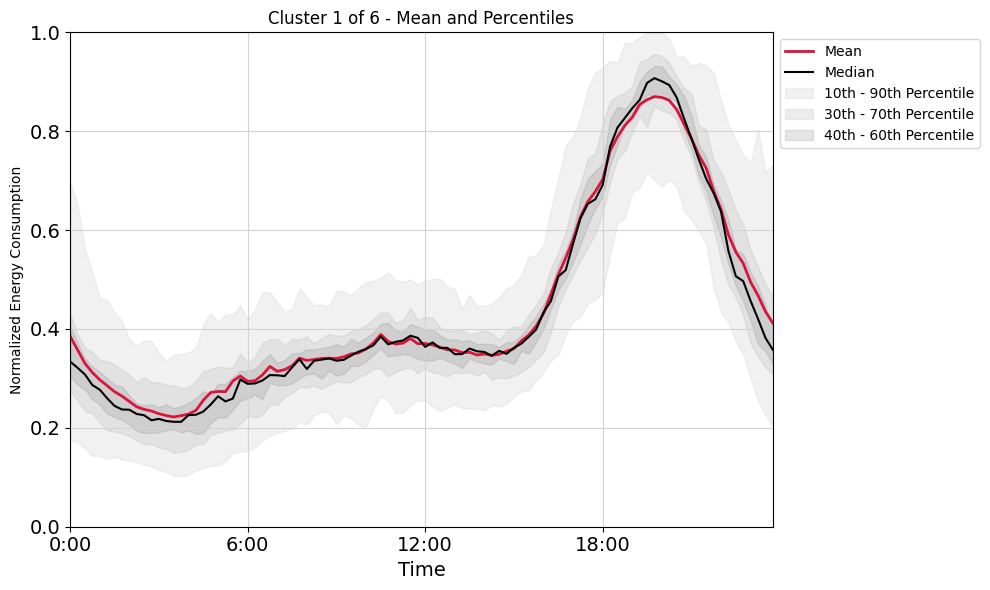

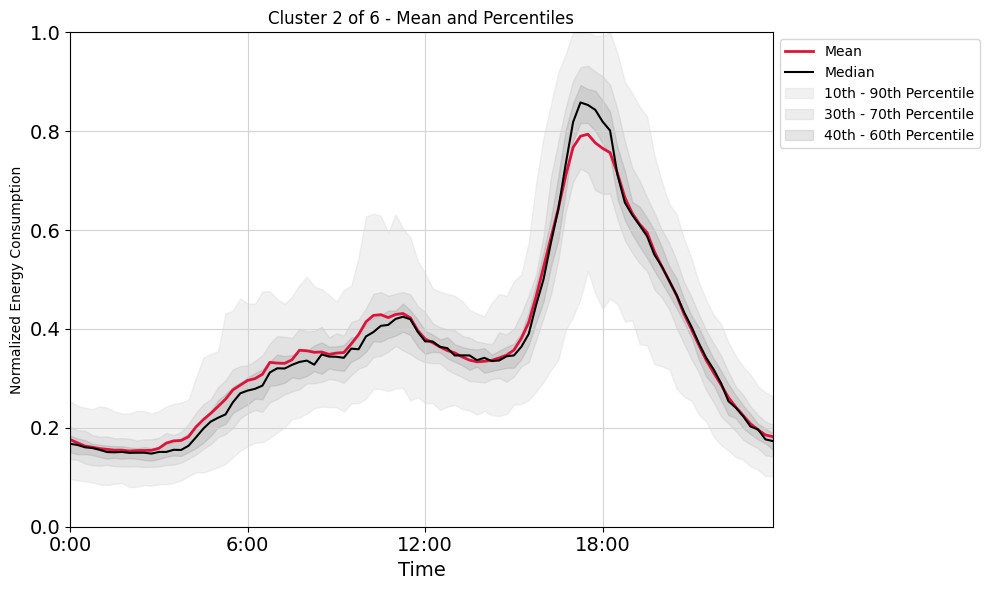

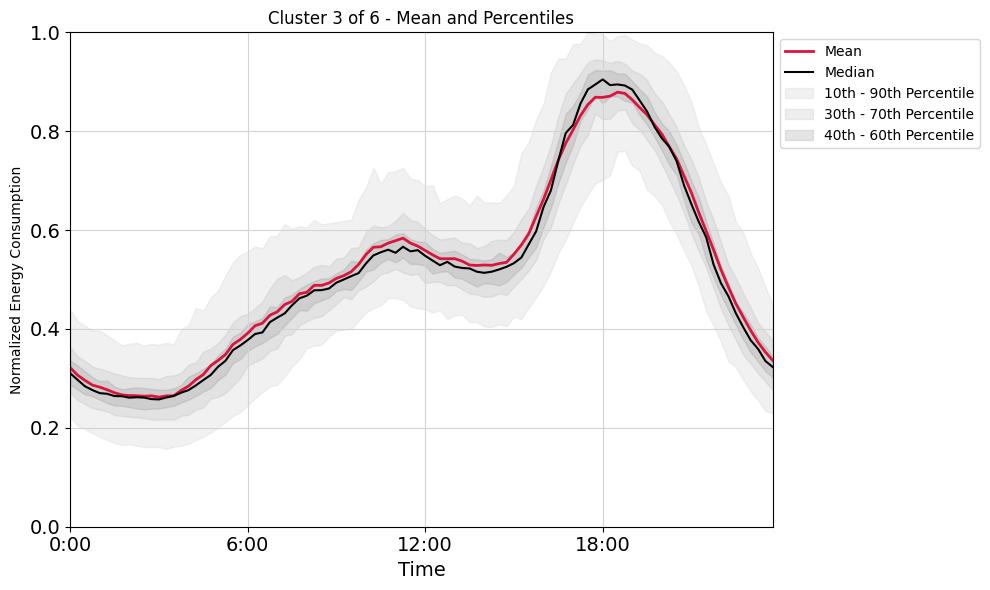

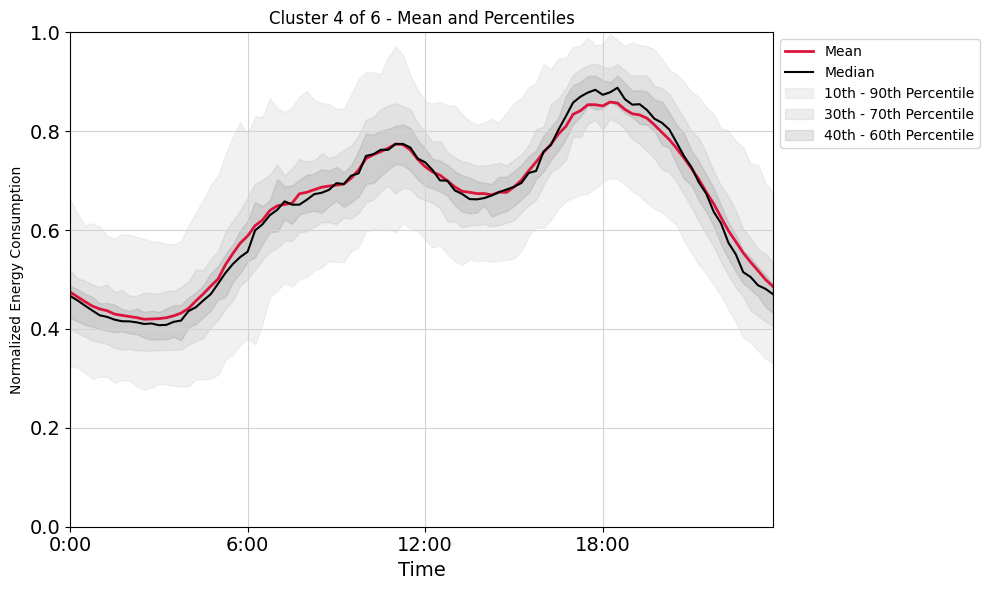

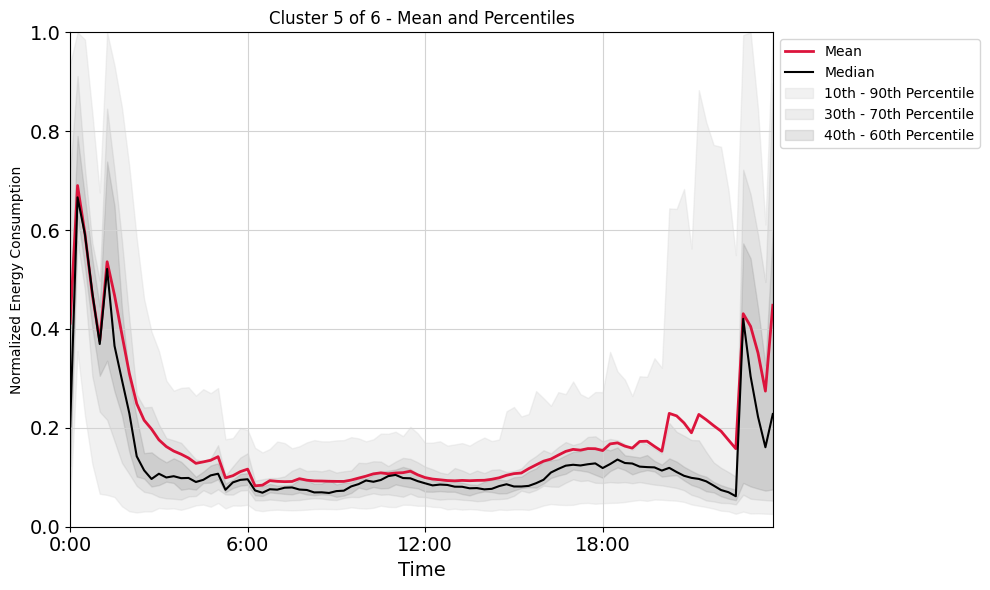

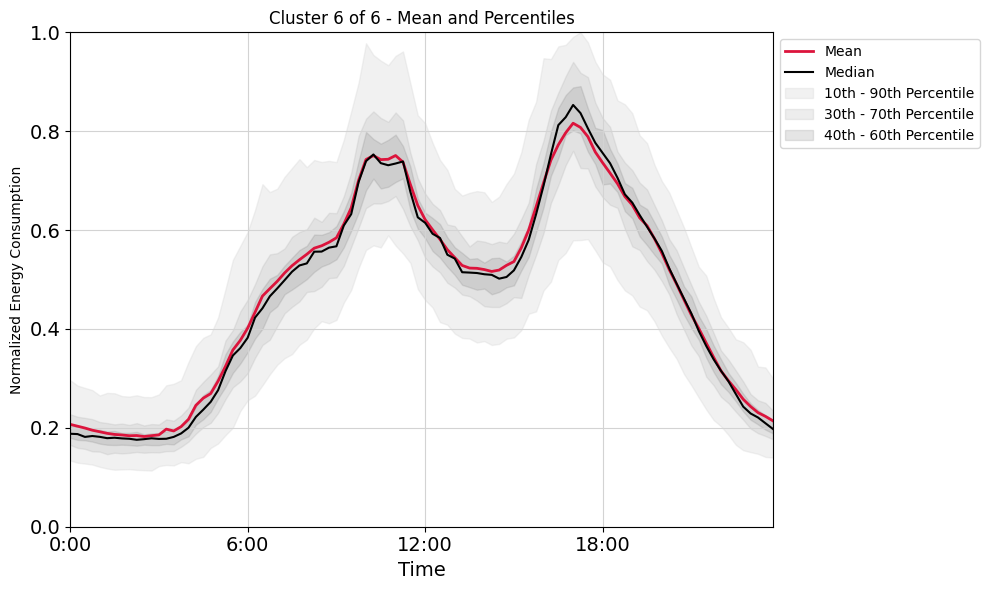

shape: (96, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ lower_per ┆ lower_per ┆ lower_per ┆ lower_per ┆ … ┆ upper_per ┆ upper_per ┆ upper_per ┆ upper_pe │
│ centile_c ┆ centile_c ┆ centile_c ┆ centile_c ┆   ┆ centile_c ┆ centile_c ┆ centile_c ┆ rcentile │
│ luster_1  ┆ luster_2  ┆ luster_3  ┆ luster_4  ┆   ┆ luster_3  ┆ luster_4  ┆ luster_5  ┆ _cluster │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ _6       │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0.174102  ┆ 0.096635  ┆ 0.222071  ┆ 0.324817  ┆ … ┆ 0.439366  ┆ 0.661385  ┆ 0.935811  ┆ 0.296466 │
│ 0.171074  ┆ 0.093779  ┆ 0.204818  ┆ 0.321644  ┆ … ┆ 0.416771  ┆ 0.633762 

In [41]:
plot_cluster_percentiles(train_data, clusters_train, number_of_clusters)

#print(train_data, clusters_train, n_clusters)

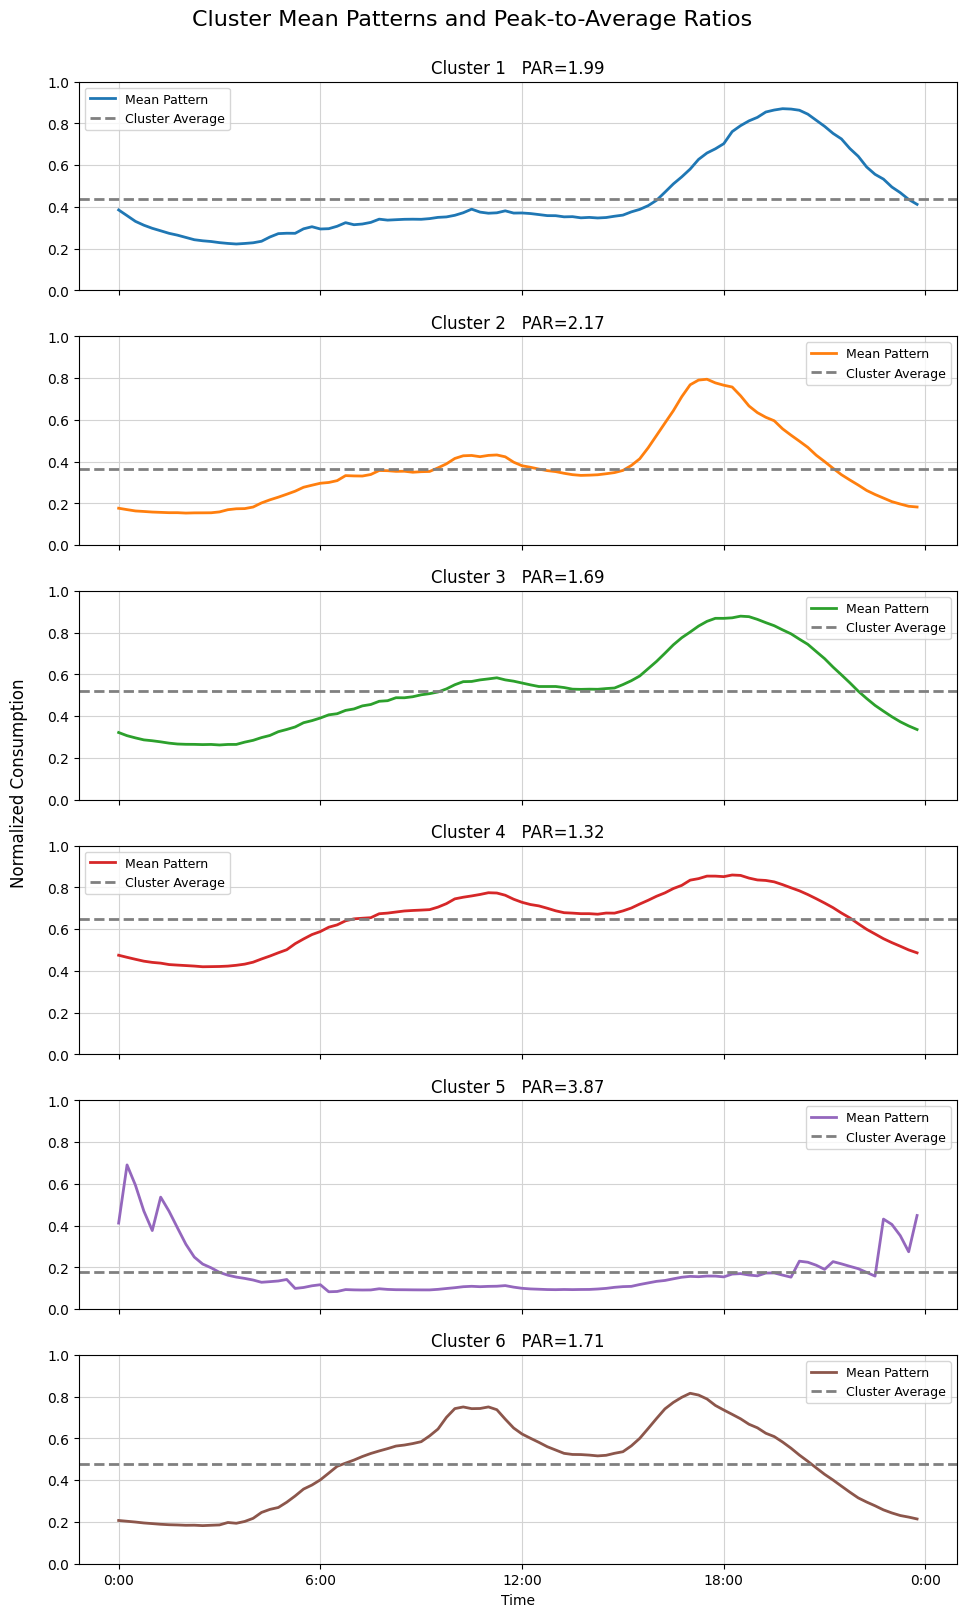

In [42]:
labels = ['0:00', '6:00', '12:00', '18:00', '0:00']
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


clusters = clusters_train + 1  # Cluster labels starting from 1
time_series_numeric = train_data.reshape((train_data.shape[0], train_data.shape[1]))

n_clusters_to_plot = np.unique(clusters)
n_clusters = len(n_clusters_to_plot)

fig, axes = plt.subplots(n_clusters, 1, figsize=(10, 2.8 * n_clusters), sharex=True)

if n_clusters == 1:
    axes = [axes]

for idx, cl in enumerate(sorted(n_clusters_to_plot)):  # Cluster 1 oben
    cluster_idx = np.where(clusters == cl)[0]
    mean_time_series = time_series_numeric[cluster_idx].mean(axis=0)
    PAR_average = np.mean(mean_time_series)
    PAR_max = np.max(mean_time_series)

    ax = axes[idx]
    ax.plot(range(1,97), mean_time_series.ravel()[:96],
            label='Mean Pattern', linewidth=2, color=colors[cl-1])
    ax.axhline(PAR_average, color='grey', linestyle='--', linewidth=2, label='Cluster Average')
    ax.set_title(f"Cluster {cl}   PAR={PAR_max/PAR_average:.2f}",
                 loc='center', fontsize=12, color='black')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.grid(color='lightgray', zorder=0)
    ax.legend(fontsize=9)
    if idx == n_clusters-1:
        ax.set_xlabel("Time")
        ax.set_xticks(range(1,120,24))
        ax.set_xticklabels(labels)
    else:
        ax.set_xticks([])  # Keine X-Ticks für die oberen Subplots
    # ACHTUNG: Kein ax.set_ylabel() hier!

fig.suptitle("Cluster Mean Patterns and Peak-to-Average Ratios", fontsize=16,  y=0.96)
fig.text(0.038, 0.5, "Normalized Consumption", va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.06, 0, 1, 0.96])
plt.savefig(
    f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Cluster/PAR_KMeans_{building_type}.png",
    bbox_inches='tight'
)
plt.show()